# Jupiter Migration Simulation

**Purpose**: Study how Jupiter's migration affects L4/L5 Trojan populations.

This notebook:
1. Loads a burn-in state (relaxed particle distribution)
2. Applies migration physics to Jupiter (inward or outward)
3. Tracks L4/L5 population evolution
4. Computes ratio slopes for comparison

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '.')

from simulation import (
    SimulationConfig,
    run_simulation,
    load_checkpoint,
    plot_trojan_evolution,
    plot_snapshot,
    create_animation,
    compute_population_summary,
    compute_jupiter_orbit
)

print('Simulation module loaded successfully!')

/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Simulation module loaded successfully!


## 2. Configuration

Choose migration direction and parameters:

In [ ]:
# === MIGRATION CONFIGURATION ===

# Migration direction: 'inward' or 'outward'
DIRECTION = 'inward'

# Migration duration in thousands of years
DURATION_KYR = 50

# Semi-major axis range (AU)
if DIRECTION == 'inward':
    INITIAL_A = 5.6  # Start further out
    TARGET_A = 5.2   # Migrate inward to current position
else:  # outward
    INITIAL_A = 4.8  # Start further in
    TARGET_A = 5.2   # Migrate outward to current position

# Input file (burn-in state to continue from)
# Set to the appropriate burn-in file for your initial_a
INPUT_FILE = f'results/pkl/jupiter_burnin_10kyr_{INITIAL_A}au.pkl'

# Number of snapshots
N_SNAPSHOTS = 200

# Create configuration
if DIRECTION == 'inward':
    config = SimulationConfig.migration_inward(
        duration_kyr=DURATION_KYR,
        initial_a=INITIAL_A,
        target_a=TARGET_A,
        input_file=INPUT_FILE,
        n_snapshots=N_SNAPSHOTS
    )
else:
    config = SimulationConfig.migration_outward(
        duration_kyr=DURATION_KYR,
        initial_a=INITIAL_A,
        target_a=TARGET_A,
        input_file=INPUT_FILE,
        n_snapshots=N_SNAPSHOTS
    )

print(f'Configuration: {config.name}')
print(f'  Direction: {DIRECTION}')
print(f'  Duration: {config.end_time:.0f} years')
print(f'  Jupiter: {INITIAL_A} AU → {TARGET_A} AU')
print(f'  Migration tau_a: {config.migration.tau_a:.0f} years')
print(f'  Input: {INPUT_FILE}')
print(f'  Output: {config.output_file}')

Configuration: jupiter_migration_50kyr_inward
  Direction: inward
  Duration: 50000 years
  Jupiter: 5.6 AU → 5.2 AU
  Migration tau_a: 674691 years
  Input: jupiter_burnin_10kyr_5.6au.pkl
  Output: jupiter_migration_50kyr_inward.pkl


## 3. Run Migration Simulation

In [3]:
# Run the simulation
results = run_simulation(config, verbose=True)

Loading checkpoint from jupiter_burnin_10kyr_5.6au.pkl...
  Time range: 0.0 - 10000.0 yr
  Snapshots: 201
Loaded initial state from t = 10000.0 yr
Running migration simulation: jupiter_migration_50kyr_inward
Duration: 50000 years
Snapshots: 200
Massive bodies: 8
Planetesimals: 1000
Migration: tau_a = 674691 yr
Snapshot 0/200: t=10000.0 yr, Jupiter r=5.538 AU, L4=17, L5=20
Snapshot 1/200: t=10250.1 yr, Jupiter r=5.559 AU, L4=24, L5=21
Snapshot 2/200: t=10500.0 yr, Jupiter r=5.581 AU, L4=23, L5=14
Snapshot 3/200: t=10750.0 yr, Jupiter r=5.574 AU, L4=21, L5=19
Snapshot 4/200: t=11000.0 yr, Jupiter r=5.537 AU, L4=19, L5=14
Snapshot 5/200: t=11250.1 yr, Jupiter r=5.486 AU, L4=20, L5=19
Snapshot 6/200: t=11500.1 yr, Jupiter r=5.440 AU, L4=19, L5=18
Snapshot 7/200: t=11750.1 yr, Jupiter r=5.392 AU, L4=17, L5=17
Snapshot 8/200: t=12000.1 yr, Jupiter r=5.334 AU, L4=23, L5=18
Snapshot 9/200: t=12250.1 yr, Jupiter r=5.311 AU, L4=24, L5=16
Snapshot 10/200: t=12500.1 yr, Jupiter r=5.361 AU, L4=16, 

## 4. Analysis

In [4]:
# Extract results
times = results['times']
l4_counts = results['l4_counts']
l5_counts = results['l5_counts']
snapshots_massive = results['snapshots_massive']
snapshots_planetesimals = results['snapshots_planetesimals']

print(f'Loaded {len(times)} snapshots')
print(f'Time range: {times[0]:.1f} - {times[-1]:.1f} yr')

Loaded 201 snapshots
Time range: 10000.0 - 60000.1 yr


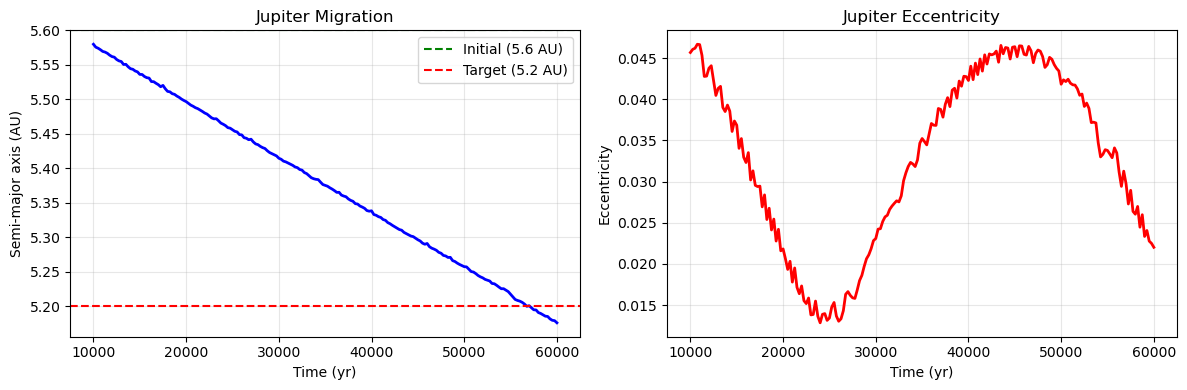

Jupiter: 5.580 AU → 5.176 AU
Eccentricity: 0.0457 → 0.0220


In [ ]:
# Track Jupiter's orbital evolution
import numpy as np
import matplotlib.pyplot as plt

jupiter_a = []
jupiter_e = []

for snap in snapshots_massive:
    orbit = compute_jupiter_orbit(snap)
    jupiter_a.append(orbit['a'])
    jupiter_e.append(orbit['e'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Semi-major axis evolution
ax1.plot(times, jupiter_a, 'b-', linewidth=2)
ax1.axhline(INITIAL_A, color='green', linestyle='--', label=f'Initial ({INITIAL_A} AU)')
ax1.axhline(TARGET_A, color='red', linestyle='--', label=f'Target ({TARGET_A} AU)')
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Semi-major axis (AU)')
ax1.set_title('Jupiter Migration')
ax1.legend()
ax1.grid(alpha=0.3)

# Eccentricity evolution
ax2.plot(times, jupiter_e, 'r-', linewidth=2)
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel('Eccentricity')
ax2.set_title('Jupiter Eccentricity')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'results/png/{config.name}_jupiter.png', dpi=150)
plt.show()

print(f'Jupiter: {jupiter_a[0]:.3f} AU → {jupiter_a[-1]:.3f} AU')
print(f'Eccentricity: {jupiter_e[0]:.4f} → {jupiter_e[-1]:.4f}')

Saved: jupiter_migration_50kyr_inward_evolution.png


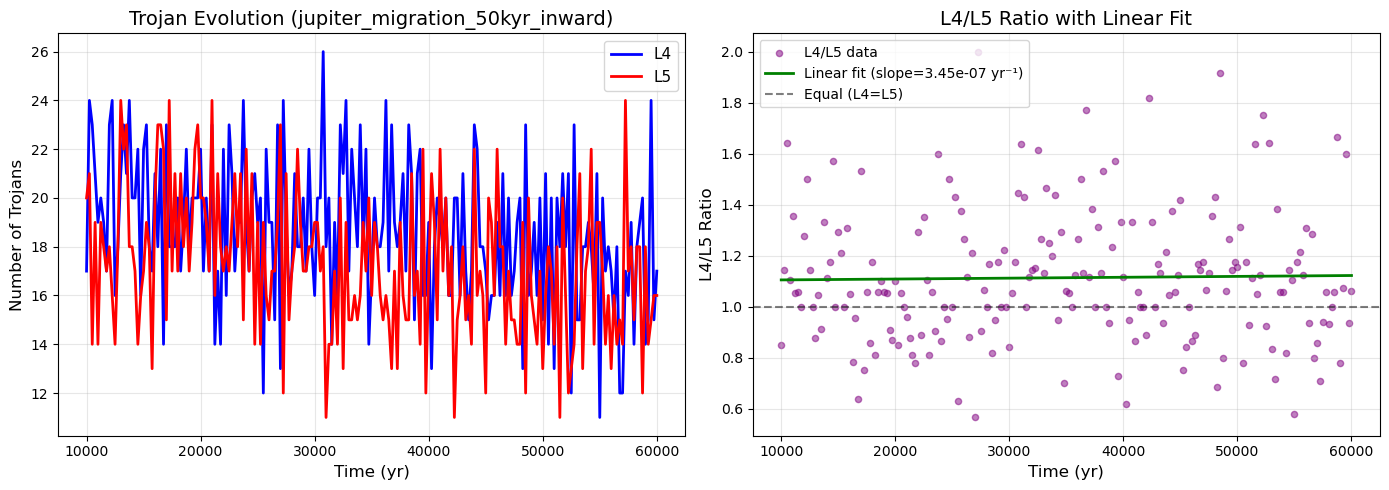

In [ ]:
# Plot Trojan population evolution
fig = plot_trojan_evolution(
    times, l4_counts, l5_counts,
    title=f'Trojan Evolution ({config.name})'
)
import os
os.makedirs('results/png', exist_ok=True)
fig.savefig(f'results/png/{config.name}_evolution.png', dpi=150)
print(f'Saved: results/png/{config.name}_evolution.png')

In [7]:
# Population summary
summary = compute_population_summary(times, l4_counts, l5_counts)

print('=' * 60)
print(f'MIGRATION SUMMARY: {DIRECTION.upper()}')
print('=' * 60)
print(f"Duration: {DURATION_KYR} kyr")
print(f"Jupiter: {INITIAL_A} → {TARGET_A} AU")
print()
print(f"Initial: L4={summary['initial_l4']}, L5={summary['initial_l5']}, Total={summary['initial_total']}")
print(f"Final:   L4={summary['final_l4']}, L5={summary['final_l5']}, Total={summary['final_total']}")
print()
print(f"Initial L4/L5 ratio: {summary['initial_ratio']:.3f}")
print(f"Final L4/L5 ratio:   {summary['final_ratio']:.3f}")
print(f"L4/L5 ratio slope:   {summary['ratio_slope']:.3e} yr⁻¹")
print()
print(f"Retention: {summary['retention_percent']:.1f}%")
print('=' * 60)

# Save slope for comparison
slope_label = f"{DURATION_KYR}kyr_{DIRECTION[:2]}"
print(f"\nFor slopes.md: {slope_label}: {summary['ratio_slope']:.3e} yr⁻¹")

MIGRATION SUMMARY: INWARD
Duration: 50 kyr
Jupiter: 5.6 → 5.2 AU

Initial: L4=17, L5=20, Total=37
Final:   L4=17, L5=16, Total=33

Initial L4/L5 ratio: 0.850
Final L4/L5 ratio:   1.062
L4/L5 ratio slope:   3.446e-07 yr⁻¹

Retention: 89.2%

For slopes.md: 50kyr_in: 3.446e-07 yr⁻¹


## 5. Batch Mode: Run Multiple Configurations

Use this section to run multiple migration scenarios and compare results.

In [ ]:
# Define multiple scenarios to run
SCENARIOS = [
    # (direction, duration_kyr, initial_a, target_a, input_file)
    ('inward', 50, 5.6, 5.2, 'results/pkl/jupiter_burnin_5kyr_5.6au.pkl'),
    ('inward', 100, 5.6, 5.2, 'results/pkl/jupiter_burnin_5kyr_5.6au.pkl'),
    ('outward', 50, 4.8, 5.2, 'results/pkl/jupiter_burnin_5kyr_4.8au.pkl'),
    ('outward', 100, 4.8, 5.2, 'results/pkl/jupiter_burnin_5kyr_4.8au.pkl'),
]

print(f'Defined {len(SCENARIOS)} scenarios for batch processing')
for i, (d, dur, a0, af, inp) in enumerate(SCENARIOS, 1):
    print(f'  {i}. {d} {dur}kyr: {a0} → {af} AU (from {inp})')

Defined 4 scenarios for batch processing
  1. inward 50kyr: 5.6 → 5.2 AU (from jupiter_burnin_5kyr_5.6au.pkl)
  2. inward 100kyr: 5.6 → 5.2 AU (from jupiter_burnin_5kyr_5.6au.pkl)
  3. outward 50kyr: 4.8 → 5.2 AU (from jupiter_burnin_5kyr_4.8au.pkl)
  4. outward 100kyr: 4.8 → 5.2 AU (from jupiter_burnin_5kyr_4.8au.pkl)


In [9]:
# Run all scenarios (uncomment to execute)
# WARNING: This will take a long time!

# all_results = []
# for direction, duration, initial_a, target_a, input_file in SCENARIOS:
#     if direction == 'inward':
#         cfg = SimulationConfig.migration_inward(
#             duration_kyr=duration,
#             initial_a=initial_a,
#             target_a=target_a,
#             input_file=input_file
#         )
#     else:
#         cfg = SimulationConfig.migration_outward(
#             duration_kyr=duration,
#             initial_a=initial_a,
#             target_a=target_a,
#             input_file=input_file
#         )
#     
#     print(f'\n{"="*60}')
#     print(f'Running: {cfg.name}')
#     print(f'{"="*60}')
#     
#     result = run_simulation(cfg, verbose=True)
#     all_results.append((cfg.name, result))

print('Batch mode ready. Uncomment the code above to run all scenarios.')

Batch mode ready. Uncomment the code above to run all scenarios.


## 6. Final Visualization

Saved: jupiter_migration_50kyr_inward_final.png


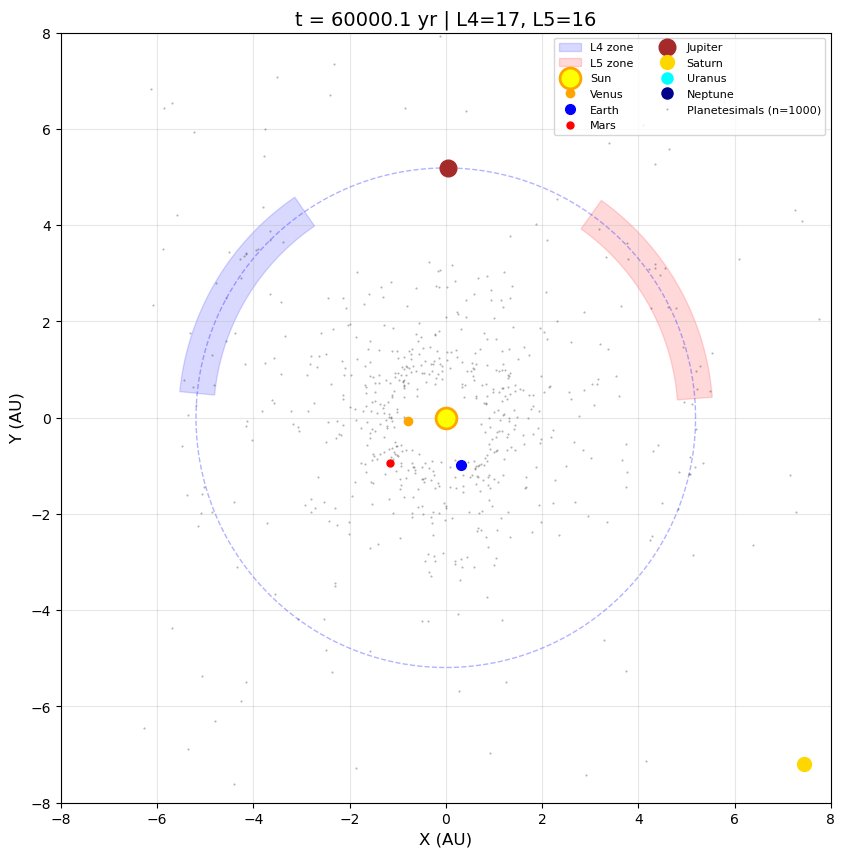

In [ ]:
# Plot final snapshot
fig = plot_snapshot(
    snapshots_massive[-1],
    snapshots_planetesimals[-1],
    times[-1],
    show_trojan_zones=True
)
fig.savefig(f'results/png/{config.name}_final.png', dpi=150)
print(f'Saved: results/png/{config.name}_final.png')

Creating animation with 201 frames...
Saving to jupiter_migration_50kyr_inward.gif...
Animation saved: jupiter_migration_50kyr_inward.gif (201 frames, 13.4s)


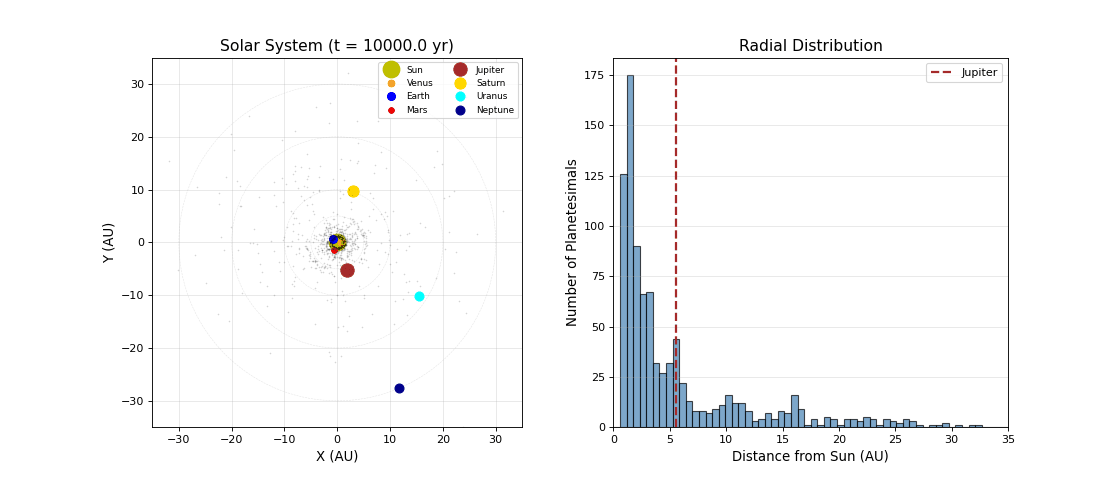

In [ ]:
# Create animation (optional)
import os
os.makedirs('results/gif', exist_ok=True)

gif_file = create_animation(
    times,
    snapshots_massive,
    snapshots_planetesimals,
    output_file=f'results/gif/{config.name}.gif',
    fps=15,
    dpi=80
)

from IPython.display import Image
Image(filename=gif_file)